<a href="https://colab.research.google.com/github/DaniilSysoev/opisis_sem_10/blob/main/%D0%9E%D0%BF%D0%B8%D1%81%D0%B8%D1%81_%D1%81%D0%B5%D0%BC_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Схемы организации двусторонней связи. Имитация работы системы двусторонней связи по двухполосной двухпроводной схеме.</h1>

<h2>Привести графики сигналов во временной и частотной областях на абонентских окончаниях в случае применения "идеальных" (на основе БПФ) и однозвенных LC-фильтров.</h2>

<h3>Добавим необходимые библиотеки</h3>

In [ ]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

<h3>Добавим функции</h3>

In [ ]:
# Гармонический сигнал
def harm_signal(t, fc):
    coef = 1 if t > 1 else t  # 0.5*t**2
    return -coef * cos(2.0 * pi * fc * t)


# Производная гармонического сигнала
def d_harm_signal(t, fc):
    coef = 1 if t > 1 else t
    return 2.0 * pi * fc1 * coef * sin(2.0 * pi * fc * t)


# Широкополосный импульс
def wb_pulse(t, fn, fv):
    freq = (fv + fn) * 0.5
    dt = 1.0 / (fv - fn)
    return exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * sin(2.0 * pi * freq * t)


# Производная широкополосного импульса
def d_wb_pulse(t, fn, fv):
    freq = (fv + fn) * 0.5
    dt = 1.0 / (fv - fn)
    a1 = 2.0 * pi * freq * t * exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * cos(2.0 * pi * freq * t)
    a2 = -2.0 * t / (2.0 * dt ** 2) * exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * sin(2.0 * pi * freq * t)
    return a1 + a2


# Перевод частоты в циклическую
def f2w(f):
    return 2.0 * pi * f


def fft_filter(time, signal, fl, fh):
    n = len(signal)
    freq = np.fft.fftfreq(n, time[1] - time[0])
    spectr = np.fft.fft(signal)
    for i in range(n):
        if not fl <= abs(freq[i]) <= fh:
            spectr[i] *= 0 + 0j
    return np.fft.ifft(spectr).real


def Z(f, L, C2):
    return (1.0 - f2w(f) ** 2 * L * C2) / (f2w(f) * C2 * 1j)


def Y(f, C1):
    return 0.5 * f2w(f) * C1 * 1j


def Gam(f, L, C1, C2):
    ZY = Z(f, L, C2) * Y(f, C1)
    return 2.0 * np.arcsinh(np.sqrt(ZY))


def lc_filter(time, signal, fn, fv, z0):
    # Расчет параметров фильтра
    f0 = 0.5 * (fn + fv)
    L = (sqrt(4.0 * z0 ** 2 * f2w(f0) ** 2 * (f2w(fv) ** 2 - f2w(f0) ** 2) /
              ((f2w(fv) ** 2 - f2w(fn) ** 2) ** 2 * (f2w(f0) ** 2 - f2w(fn) ** 2))))
    C1 = 2.0 / L / (f2w(fv) ** 2 - f2w(fn) ** 2)
    C2 = 1.0 / (f2w(fn) ** 2 * L)

    n = len(signal)
    freq = np.fft.fftfreq(n, time[1] - time[0])
    spectr = np.fft.fft(signal)
    for i in range(n):
        spectr[i] *= 0 if freq[i] == 0 else exp(-Gam(abs(freq[i]), L, C1, C2).real)
    return np.fft.ifft(spectr).real

<h3>Введем необходимые данные</h3>

In [ ]:
ideal_filter = False
pulse1 = True
pulse2 = True

fc1 = 6  # Вещание в полосе частот [4..8]
fc2 = 14  # Вещание в полосе частот [12..16]
Tc = float(input('Временной интервал '))

fl = float(input('Нижняя граничная частота ЛП '))
fh = float(input('Верхняя граничная частота ЛП '))
f0 = (fc1 + fc2) * 0.5  # (fl + fh) * 0.5
Z0 = float(input('Характеристическое сопротивление одного звена ЛП на частоте ' + str(f0) + ' '))
Nc = int(input('Число ячеек в ЛП '))

Временной интервал 10
Нижняя граничная частота ЛП 1
Верхняя граничная частота ЛП 100
Характеристическое сопротивление одного звена ЛП на частоте 10.0 600
Число ячеек в ЛП 10


<h3>Рассчитаем параметры отдельной ячейки ЛП</h3>

In [ ]:
L = (sqrt(4.0 * Z0 ** 2 * f2w(f0) ** 2 * (f2w(fh) ** 2 - f2w(f0) ** 2) /
          ((f2w(fh) ** 2 - f2w(fl) ** 2) ** 2 * (f2w(f0) ** 2 - f2w(fl) ** 2))))
C1 = 2.0 / L / (f2w(fh) ** 2 - f2w(fl) ** 2)
C2 = 1.0 / (f2w(fl) ** 2 * L)
G = 0

print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))


Параметры отдельной ячейки ЛП:
C1 =  0.000003
C2 =  0.013262
L =  1.910050


<h3>Рассчитаем необходимые параметры</h3>

In [ ]:
npp = 10  # Количество точек на период гармонического сигнала
dt = 1 / (max(fc1, fc2) * npp)  # Шаг по времени
num = int(Tc / dt)  # Количество временных отсчетов

freq = np.linspace(0.8 * fl, fh * 1.2, num)

A0 = 1  # Амплитуда сигнала в направлении слева направо
AN = 1  # Амплитуда сигнала в направлении справа налево
K0 = KN = 1  # Коэффициенты при нагрузочных сопротивлениях

# Количество итераций для решения уравнений возбуждения
dpp = 50
print('dpp = {0: d}'.format(dpp))

dpp =  50


<h3>Рассчитаем массивы данных</h3>

In [ ]:
aU = [0] * Nc  # Массив напряжений на емкости C2
dU = [0] * Nc  # Массив производных напряжений на емкости C2
aV = [0] * (Nc + 1)  # Массив напряжений на емкости C1
dV = [0] * (Nc + 1)  # Массив производных напряжений на емкости C1

Vinp = [0] * num  # Массив входных напряжений
Vout = [0] * num  # Массив выходных напряжений
time = [0] * num  # Массив временных отсчетов

Vs = [0] * npp  # Массив напряжений на C1 вдоль ЛП на одном периоде сигнала
for i in range(npp): Vs[i] = [0] * (Nc + 1)

<h3>Решение уравнений возбуждения ЛП</h3>

In [ ]:
for it in range(num):
    time[it] = dt * it
    for i in range(dpp):
        d_signal1 = d_wb_pulse(time[it], 4, 8) if pulse1 else d_harm_signal(time[it], fc1)
        dV[0] += (1.0 / (L * C1) * (aV[1] - aV[0] + aU[0]) + 1.0 / (Z0 * K0 * C1) * (A0 * d_signal1 - dV[0])) * dt / dpp
        for ic in range(Nc):
            dU[ic] += (1.0 / (L * C2) * (aV[ic] - aV[ic + 1] - aU[ic]) - G / C2 * dU[ic]) * dt / dpp
            if ic == 0: continue
            dV[ic] += (0.5 / (L * C1) * (aV[ic - 1] - 2.0 * aV[ic] + aV[ic + 1] + aU[ic] - aU[ic - 1])) * dt / dpp
        d_signal2 = d_wb_pulse(time[it], 12, 16) if pulse2 else d_harm_signal(time[it], fc2)
        dV[Nc] += (1.0 / (L * C1) * (aV[Nc - 1] - aV[Nc] - aU[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    AN * d_signal2 - dV[Nc])) * dt / dpp

        for ic in range(Nc):
            aV[ic] += dV[ic] * dt / dpp
            aU[ic] += dU[ic] * dt / dpp
        aV[Nc] += dV[Nc] * dt / dpp

    if num - it <= npp:
        for ic in range(Nc + 1):
            Vs[it - (num - npp)][ic] = aV[ic]

    Vinp[it] = aV[0]
    Vout[it] = aV[Nc]
    if it % 100 == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp[it], Vout[it]))

if ideal_filter:
    v_left = fft_filter(time, Vinp, 12, 16)
    v_right = fft_filter(time, Vout, 4, 8)
else:
    v_left = lc_filter(time, Vinp, 12, 16, Z0)
    v_right = lc_filter(time, Vout, 4, 8, Z0)

  0.000   0.000   0.000 
  0.714  -0.000   0.000 
  1.429  -0.000   0.000 
  2.143   0.000   0.000 
  2.857   0.000   0.000 
  3.571  -0.000   0.000 
  4.286  -0.054   0.000 
  5.000  -0.467  -0.328 
  5.714  -0.001   0.070 
  6.429  -0.000   0.000 
  7.143  -0.000   0.000 
  7.857  -0.000   0.000 
  8.571  -0.000   0.000 
  9.286  -0.000   0.000 


<h3>Расчет спектра сигналов слева и справа</h3>

In [ ]:
spectr_inp = np.abs(np.fft.fft(Vinp)) / num * 2
spectr_out = np.abs(np.fft.fft(Vout)) / num * 2
fft_freq = np.fft.fftfreq(num, Tc / num)

<h3>Построим полученные сигналы и их спектры до и после прохождения через фильтры</h3>

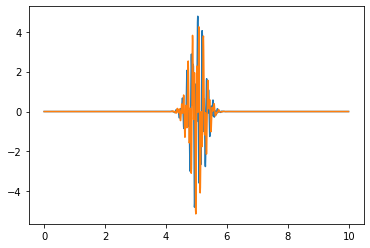

In [ ]:
plt.plot(time, Vinp, time, Vout)
plt.show()

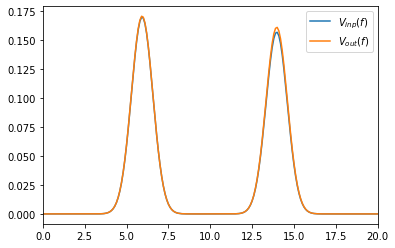

In [ ]:
plt.plot(fft_freq[0:num // 2], spectr_inp[0:num // 2], label='$V_{inp}(f)$')
plt.plot(fft_freq[0:num // 2], spectr_out[0:num // 2], label='$V_{out}(f)$')
plt.axis(xmin=0, xmax=20)
plt.legend(loc='best')
plt.show()

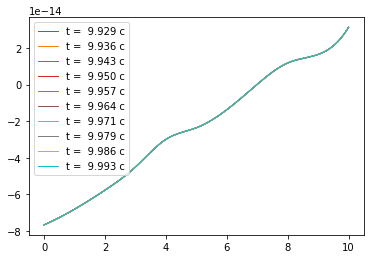

In [ ]:
cells = np.linspace(0, Nc, Nc + 1)
z_spl = np.linspace(0, Nc, (Nc + 1) * 10)
for i in range(npp):
    spl = make_interp_spline(cells, Vs[i], k=3)
    plt.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
plt.legend(loc='best')
plt.show()

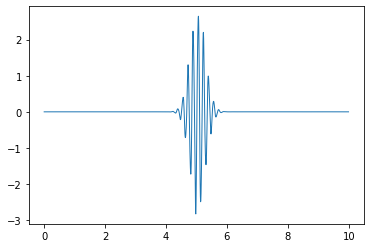

In [ ]:
sig_l = [0] * num
sig_r = [0] * num
for i in range(num):
    sig_l[i] = 2.0 * wb_pulse(time[i], 4, 8) if pulse1 else 0.5 * harm_signal(time[i], fc1)
    sig_r[i] = 2.0 * wb_pulse(time[i], 12, 16) if pulse2 else 0.5 * harm_signal(time[i], fc2)

# plt.plot(time, sig_l, lw=1, label='$V_{исх}(t)$')
plt.plot(time, v_right, lw=1, label='$V_{справа}(t)$')
plt.show()

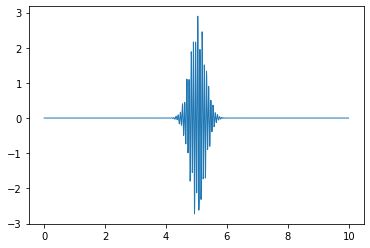

In [ ]:
# plt.plot(time, sig_r, lw=1, label='$V_{исх}$')
plt.plot(time, v_left, lw=1, label='$V_{слева}$')
plt.show()


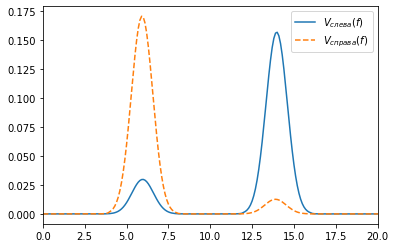

In [ ]:
spectr_left = np.abs(np.fft.fft(v_left)) / num * 2
spectr_right = np.abs(np.fft.fft(v_right)) / num * 2
fft_freq = np.fft.fftfreq(num, Tc / num)
plt.plot(fft_freq[0:num // 2], spectr_left[0:num // 2], label='$V_{слева}(f)$')
plt.plot(fft_freq[0:num // 2], spectr_right[0:num // 2], '--', label='$V_{справа}(f)$')
plt.axis(xmin=0, xmax=20)
plt.legend(loc='best')
plt.show()

<h2>Дополнительное задание: привести графики сигналов во временной и частотной областях на абонентских окончаниях при использовании трехзвенных LC-фильтров.</h2>

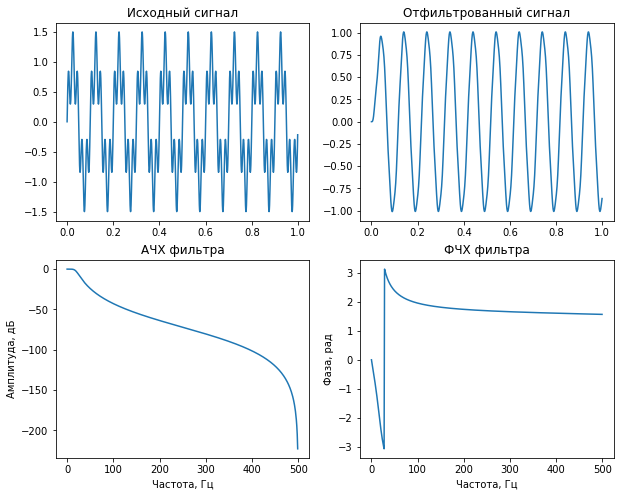

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

# Создание тестового сигнала
fs = 1000 # частота дискретизации
duration = 1 # длительность сигнала
t = np.arange(0, duration, 1/fs)
f1 = 10 # частота первой гармоники
f2 = 50 # частота второй гармоники
signal = np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t)

# Проектирование фильтра
fc = 20 # частота среза
w = fc / (fs/2)
b, a = butter(3, w, 'low')

# Фильтрация сигнала
filtered_signal = lfilter(b, a, signal)

# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0, 0].plot(t, signal)
axs[0, 0].set_title('Исходный сигнал')
axs[0, 1].plot(t, filtered_signal)
axs[0, 1].set_title('Отфильтрованный сигнал')
w, h = freqz(b, a)
freq = w / (2*np.pi) * fs
axs[1, 0].plot(freq, 20 * np.log10(abs(h)))
axs[1, 0].set_title('АЧХ фильтра')
axs[1, 0].set_xlabel('Частота, Гц')
axs[1, 0].set_ylabel('Амплитуда, дБ')
axs[1, 1].plot(freq, np.angle(h))
axs[1, 1].set_title('ФЧХ фильтра')
axs[1, 1].set_xlabel('Частота, Гц')
axs[1, 1].set_ylabel('Фаза, рад')
plt.show()